In [111]:
import matplotlib.pyplot as plt
import copy

from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
from obspy.core.event import Catalog
from obspy.core.stream import Stream
from obspy import read_events
from obspy import read_inventory

In [2]:
client=Client('INGV')

stime=UTCDateTime('2023-09-27T00:00:00')
etime=UTCDateTime('2023-10-03T00:00:00')
lat=40.8478
long=14.0918
rad_events=0.3

### includearrivals: include picks, used for get_wavelets 

In [3]:
cat=client.get_events(starttime=stime,endtime=etime,includearrivals=False,          
                      latitude=lat,longitude=long,maxradius=rad_events,
                      minmagnitude=2)    

cat               

11 Event(s) in Catalog:
2023-10-02T20:08:26.650000Z | +40.830,  +14.149 | 4.0  Md | manual
2023-10-01T13:33:09.009000Z | +40.833,  +14.139 | 2.9  Md | manual
...
2023-09-27T08:45:27.359000Z | +40.819,  +14.142 | 2.1  Md | manual
2023-09-27T01:35:34.359000Z | +40.817,  +14.156 | 4.2  Md | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

### create new catalogue with only manual events

In [4]:
cat2=Catalog()

#type(cat[0]['origins'][0])
cat[0]['origins'][0].evaluation_mode

for ev in cat:
    if ev['origins'][0].evaluation_mode == 'manual':
        eid=ev.resource_id.id.split('=')[1]                                         #id number
        cat2 += client.get_events(includearrivals=True,eventid=eid)
        

cat2

11 Event(s) in Catalog:
2023-10-02T20:08:26.650000Z | +40.830,  +14.149 | 4.0  Md | manual
2023-10-01T13:33:09.009000Z | +40.833,  +14.139 | 2.9  Md | manual
...
2023-09-27T08:45:27.359000Z | +40.819,  +14.142 | 2.1  Md | manual
2023-09-27T01:35:34.359000Z | +40.817,  +14.156 | 4.2  Md | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

### plot events location and mag with cartopy package 

In [5]:
#cat2.plot() 

In [6]:
cat2[0].picks[0].evaluation_mode

'manual'

### eliminate automatic picking from catalogue

In [7]:
for ev in cat2:
    len_pre=len(ev.picks)
    ind_picks=[]
    for ind,pick in enumerate(ev.picks):
        if pick.evaluation_mode == 'automatic':
            ind_picks.append(ind)
    
    for ind in reversed(ind_picks):
        del ev.picks[ind]
    len_post=len(ev.picks)
    print(len_pre,'-------',len_post)

#for ind in cat2[0].picks:
#    print(ind.evaluation_mode)
cat2.write('cat_flegrei.xml',format='QUAKEML')


129 ------- 68
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
0 ------- 0
169 ------- 86


some events have no picks (bad)

In [8]:
cat2[10].resource_id

cat_miss=client.get_events(eventid='36352871',includearrivals=True)
cat_miss[0].picks


[]

# WAVEFORMS

load catalogue from local

In [9]:
catf=read_events('cat_flegrei.xml')

In [10]:
rad_stations=0.1
inv=client.get_stations(starttime=stime,endtime=etime,
                        latitude=lat,longitude=long,maxradius=rad_stations,
                        level='response')                                   #instrumental response

inv

Inventory created at 2023-11-09T10:03:00.278000Z
	Created by: INGV-ONT WEB SERVICE: fdsnws-station | version: 1.1.57
		    /exist/apps/fdsn-station/fdsnws/station/1/query?starttime=2023-09-2...
	Sending institution: eXistDB (INGV-ONT)
	Contains:
		Networks (2):
			IV, IX
		Stations (15):
			IV.CAAM (Accademia Aeronautica Pozzuoli)
			IV.CBAC (Campi Flegrei, Castello di Baia - Stazione Osservatorio Vesu)
			IV.CCAP (Capo Posillipo C. acqisiz. - Stazione Osservatorio Vesuviano)
			IV.CFMN (Monte Nuovo)
			IV.CMIS (Faro di Capo Miseno - Stazione Osservatorio Vesuviano)
			IV.CMSN (Monte S.Angelo)
			IV.CNIS (Campi Flegrei - Isola di Nisida)
			IV.COLB (Campi Flegrei, Galleria Monte Olibano, Stazione Osservatorio)
			IV.CPOZ (Darsena Pozzuoli - Stazione Osservatorio Vesuviano)
			IV.CQUE (Campi Flegrei Quarto EST - Stazione Osservatorio Vesuviano)
			IV.CSFT (Campi Flegrei - Cratere Solfatara, Interno)
			IV.CSOB (Solfatara Bordo Cratere - Stazione Osservatorio Vesuviano)
			IV.CSTH (Solfa

In [11]:
inv.write('inventory_f.xml',format='STATIONXML')                        #save

inv_f=read_inventory('inventory_f.xml')


In [125]:
event_start=catf[0].origins[0].time
event_end=catf[0].origins[0].time +30


wave=Stream()
for  station in inv_f.networks[0].stations:
    try:
        wave += client.get_waveforms(starttime=event_start,endtime=event_end,
                            network='IV',station=station.code,location='*', channel='EH?,HH?',
                            attach_response=True,)
    except:
        print(station.code , 'station not found')
wave.__dict__

CPOZ station not found
CQUE station not found


{'traces': [IV.CAAM..HHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CAAM..HHN | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CAAM..HHZ | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CBAC..HHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CBAC..HHN | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CBAC..HHZ | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CCAP..EHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CCAP..EHN | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CCAP..EHZ | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CFMN..HHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.

In [126]:
wave.traces[0].stats.sampling_rate

100.0

In [127]:
for tr in wave.traces:
    if tr.stats.sampling_rate == 200.:
        wave.remove(tr)

wave

39 Trace(s) in Stream:

IV.CAAM..HHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples
...
(37 other traces)
...
IV.PTMR..HHZ | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

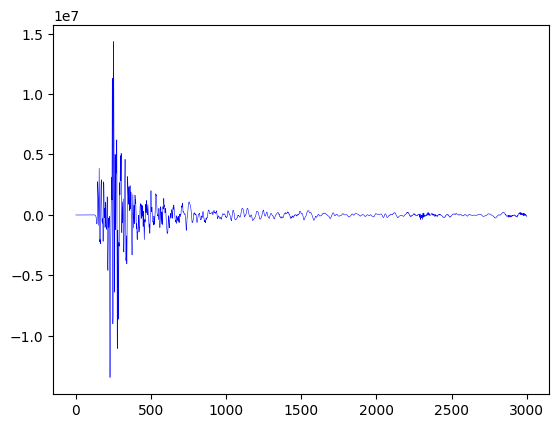

In [128]:
s=wave.traces[1].data
plt.figure('s')
plt.plot(s,'b',linewidth=0.4)
plt.show()

In [132]:
wave.write('wave_f.mseed',format='MSEED')

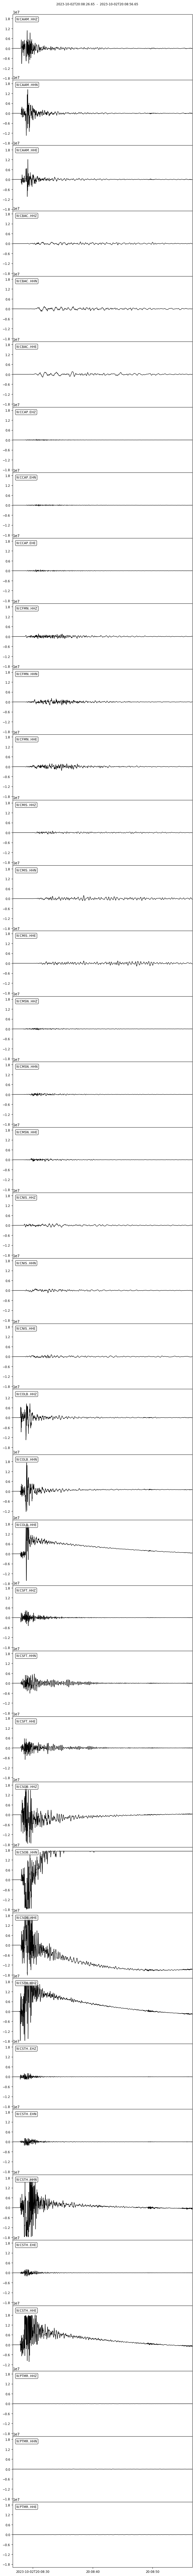

In [129]:
wave.plot();

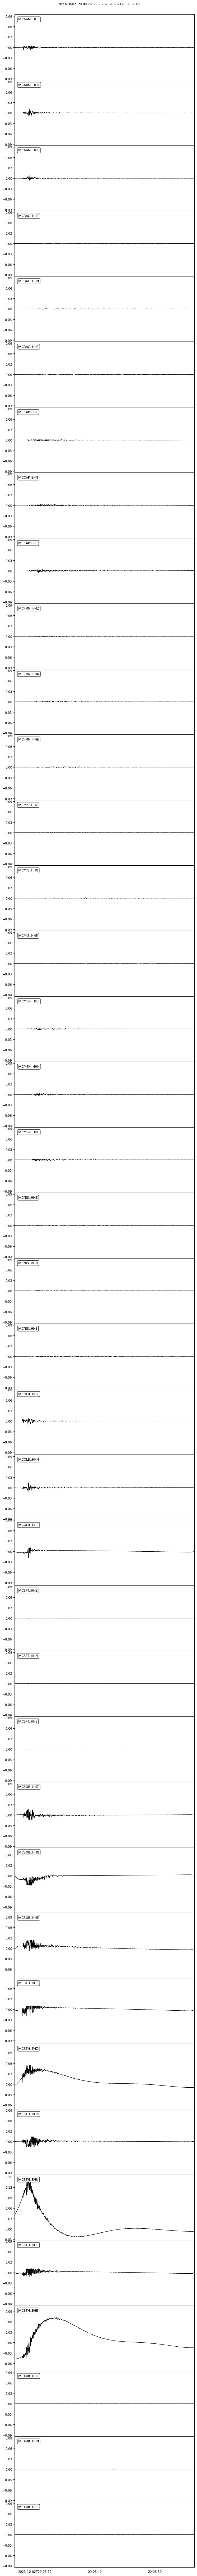

In [130]:
wave_response=copy.deepcopy(wave)
wave_response.remove_response(output="VEL")
wave_response.plot();